In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from QuantumWalk.QWAK import QWAK
from sympy import Matrix, gcd, div, Poly, Float, pprint
from sympy.abc import pi
from math import sqrt, ceil, pow

In [77]:
### Algorithm to check PST based on the article https://arxiv.org/abs/1606.02264 authored by Rodrigo Chaves

## For a graph to have PST it needs to obey numerous rules and the first one is that the vertices with PST must be 
# strongly cospectral. Two vertices a and b are strong cospectral if the characteristic polynomial of the matrix Ma, that has
# the colum and row a removed, is equal to the characteristic polynomial of the matrix Mb, that has the column and row b 
# removed. This is easily checked using SymPy and it is what the function StrCospec does. 
def StrCospec(A,a,b):
    Ma= A.minor_submatrix(a,a)
    Mb = A.minor_submatrix(b,b)
    Mab = Ma.minor_submatrix(b-1,b-1)
    
    phi = A.charpoly()
    phia = Ma.charpoly()
    phib = Mb.charpoly()
    phiab = Mab.charpoly()
    
    if phia != phib or not SimplePoles(phi,phiab):
        return False
    else:
        return True
    
## The second condition for strong cospectral is that the poles of phiab/phi must be simple. This is trickier to check and
# it starts by defning a polynomial g(x)=gcd(phi,phiab). Then, there will be no poles if f(x) = phi/g(x) is a polynomial 
# without repeated roots. This occurs when gcd(f(x),f'(x)) is a constant, then we only need to check the coeeficients and
# see if all of them is zero except the last one. This is done by the function SimplePoles.
    
def SimplePoles(phi,phiab):
    gx = gcd(phi,phiab)
    fx,r = div(phi,gx)
    fx_der = fx.diff()
    great = gcd(fx,fx_der)
    coeffs = great.all_coeffs()
    del coeffs[len(coeffs)-1]
    for coeff in coeffs:
        if coeff > 0:
            return False
    return True

## One of the steps requires that we find square-free numbers, that is, numbers that have a prime decomposition with all 
# primes being unique. Fist we use the Sieve of Eratosthenes, and the corresponding function, to find all primes from 1 to n.
# It works by choosing the first prime in the list, in this case 2, then squareing it and removing all its multiples from the
# list. The algorithm then choose the next prime and does the same procedure. At the end, we have a list with True at position
# i if i+1 is prime and False otherwise.

def SieveEratosthenes(n):
    isPrime = np.full([n,1],True)
    for i in range(2,ceil(sqrt(n))+1):
        if isPrime[i-1]:
            for j in range(int(pow(i,2)),n+1,i):
                isPrime[j-1]=False
    return isPrime

## The function SquareFree gives a list of square-free number from 1 to n in a similar way that we found all primes. The 
# algorithm get the list of primes from 1 to n, then it start a loop of integers from 2 to n, when i is prime the algorithm
# associates False to all multiples of i². It returns a list with True (False) in the entry i if i-1 is (not) square free.

def SquareFree(n):
    isSqrFree = np.full([n,1],True)
    isPrime = SieveEratosthenes(n)
    SqrFreeList = []
    for i in range(2,n+1):
        if isPrime[i-1]:
            for j in range(int(pow(i,2)),n+1,int(pow(i,2))):
                isSqrFree[j-1]=False
    for i in range(n):
        if isSqrFree[i]:
            SqrFreeList.append(i+1)
    return SqrFreeList

## EigenSupp is responsible for getting the eigenvalue support of the vertice a. The eigenvalue support of the vertice a is
# all the eigenvalues such that Er|a> != 0, where |a> is vector with 1 in the a-th entry and zero in all others and Er is the
# projection matrix of the eigenvalue r. It returns a list with all those eigenavlues. This is one of the conditions for PST,
# because we do not need to check for eigenvalues that are not in the eigenvalue support.

def EigenSupp(a,eigenvec,eigenval):
    supp = []
    for i in range(len(eigenval)):
        if eigenvec.col(i)[a] != 0:
            supp.append(eigenval[i])
    return supp

## CheckRoots is responsible for checking the second condition for PST which is that all eigenvalues is the eigenvalue support
# of a must be all integers or all quadratic integers with the format p+qr*Sqrt(delta)/2, with qr changing from eigenvalue to
# to eigenvalue. The frist step is to define h(x) = phi/gcd(phi,phia) that have all its roots in the eigenvalue support of a,
# then its degree k will be crucial. 

def CheckRoots(A, a, eigenvec, eigenval):
    supp = EigenSupp(a,eigenvec,eigenval)
    Ma =  Ma= A.minor_submatrix(a,a)
    phi = A.charpoly()
    phia = Ma.charpoly()
    h,r = div(phi,gcd(phi,phia))
    k = h.degree()
    
    ## First, we check for integer roots in the interval [-n^4,n^4] that the eigenvalues should be. We check by putting the
    # value in the loop, i, direct into h(i) and we see if it is equal to zero. If it is, then we check if i is in the 
    # eigenvalue support of a. With both conditions satisfied, it stores 1 to delta and sum one to intRoots.
    
    intRoots = 0
    for i in range(-len(eigenval)**4,len(eigenval)**4+1):
        if h(i)==0 and i in supp:
            delta = 1
            intRoots += 1
    
    ## Then we check if all roots are quadratic integers p+qr*Sqrt(delta)/2. We know that p will be equal to the coefficient
    # of the second bigest power of h(x). Then, all we need to do is loop through the values of delta in the list of square-free
    # integers. Then, we loop qr until it is bigger than Sqrt(Tr(A²)) and check if is a root of h(x) and it is also in the
    # eigenvalue support of a. In case it is true, we store the value of delta and sum one to quadRoots.
    
    quadRoots = 0
    sqrtFreeInt = SquareFree(int((4*A**2).trace()))
    p = h.all_coeffs()[1]
    for deltaS in sqrtFreeInt:
        q = 0
        while (p+q*sqrt(deltaS)/2) <= sqrt(int(((A**2).trace()))):
            if h(p+q*sqrt(deltaS)/2) == 0 and Float(p+q*sqrt(deltaS)/2,3) in supp:
                quadRoots += 1
            q += 1
    if quadRoots > 0:
        delta = deltaS
    
    ## Here we check if quadRoots or intRoots are bigger than k, which is the degree of our polynomial h(x). If none of them is
    # then we know that PST is not possible and we return False.
    
    if quadRoots < k and intRoots < k:
        return False, 0, 0
    
    ## The time that PST occurs is just pi/g*Sqrt(delta) where g = gcd(theta0 - thetar), i.e. the gcd between all the differences
    # of the eigenvalue theta0 (the biggest eigenvalue) and all others eigenvalues.
    
    diffs=[]
    for i in range(len(supp)):
        diffs.append(max(supp)-supp[i]/sqrt(delta))
    
    g=0
    for diff in diffs:
        g = gcd(g,diff)
    
    return True, g, delta

## Finally, CheckPST checks if all the conditions are true and return True if the graph has PST and False otherwise.

def checkPST(A,a,b):
    if a > b:
        temp = a
        a = b
        b = temp
    A = Matrix(A)
    (eigenvec,D) = A.diagonalize()
    eigenval = []
    
    ## Notice that I was having rouding problems because Python was not considering 6x10^-50 to be zero, so I made a loop
    # to garantee that it is zero.
    for i in range(len(D.col(0))):
        temp = D.col(i)[i]
        if abs(temp) < 0.0000001:
            temp = 0
        eigenval.append(temp)
    
    result, g, delta = CheckRoots(A,a,eigenvec,eigenval)
    if StrCospec(A,a,b) and result:
        return True, pi/(g*sqrt(delta))
    else:
        return False, =

In [62]:
n = 4
t = 2
gamma = 1 / (2 * np.sqrt(2))
graph = nx.cycle_graph(n)
# graph = nx.circular_ladder_graph(n)
marked = [int(n / 2)]

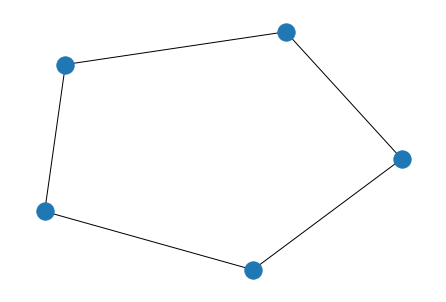

In [63]:
# nx.draw(nx.circular_ladder_graph(10))
nx.draw(nx.cycle_graph(5))

In [64]:
qwController = QWAK(graph, laplacian=False)
qwController.runWalk(t,gamma, marked)

init state inside variable [2]
init state inside [2]


In [65]:
qwProbabilities = qwController.getProbDist()
qwAmplitudes = qwController.getWalk()
print(f"Mean = {qwProbabilities.mean()}")
print(f"Standard Deviation = {qwProbabilities.stdev()}")

Mean = 1.643784476796836
Standard Deviation = 1.0360416639628374


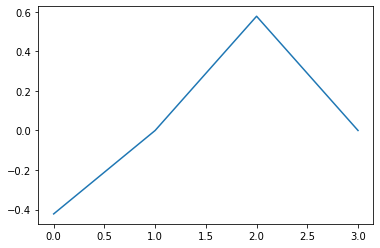

In [66]:
plt.plot(qwAmplitudes.getStateVec())

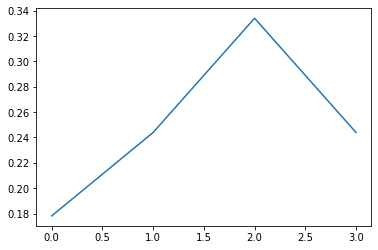

In [67]:
plt.plot(qwProbabilities.getProbVec())

In [79]:
# print((qwController.getOperator().getAdjacencyMatrix()).tolist())
type(checkPST(qwController.getOperator().getAdjacencyMatrix(),0,2))

sympy.core.mul.Mul

In [9]:
n = 5
t = 30
gamma = 1 / (2 * np.sqrt(2))
graph = nx.hypercube_graph(n)
marked = [int(n / 2)]

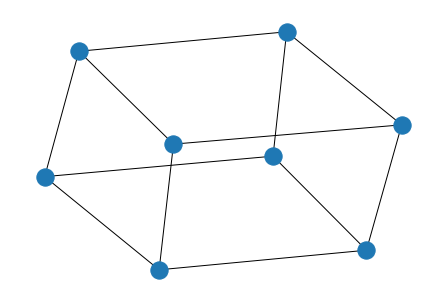

In [10]:
nx.draw(nx.hypercube_graph(3))

In [11]:
qwController = QWAK(graph, laplacian=False)
qwController.runWalk(t,gamma,[10])

init state inside variable [10]
init state inside [10]


In [12]:
qwProbabilities = qwController.getProbDist()
qwAmplitudes = qwController.getWalk()
print(f"Mean = {qwProbabilities.mean()}")
print(f"Standard Deviation = {qwProbabilities.stdev()}")

Mean = 19.41796447445253
Standard Deviation = 6.479942379687402


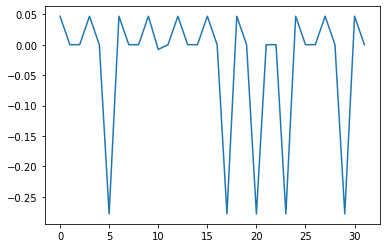

In [13]:
plt.plot(qwAmplitudes.getStateVec())